In [1]:
from knapsax.utils import setrootdir

setrootdir("knapsax")

'Directory knapsax successfully loaded as current working directory.'

In [2]:
from knapsax.optimization import Knapsack
from knapsax.aco import ACO
from knapsax.stats import Stats

In [3]:
knapsack = Knapsack(instance_file="data/knapsack-instance.txt")
knapsack

Knapsack(file=data/knapsack-instance.txt, n_items=100, capacity=1550)

In [4]:
aco_stats = Stats(
    n_runs=20,
    algorithm_class=ACO,
    knapsack=knapsack,
    n_ants=200, n_iterations=100, decay=0.95,
    pheromone_intensity=0.00001, n_best=3,
    alpha=1, beta=1
)

aco_stats.run()

Running ACO: 100%|██████████| 20/20 [19:28<00:00, 58.44s/run]  


In [5]:
df_aco = aco_stats.frame()
df_aco

,iteration,best_solution,best_value,best_weight,history_value,history_weight,execution_time,memory_peak,memory_peak_mb
0,0,"[2043, 2076, 2076, 2095, 2095, 2095, 2095, 209...",2181,1548,"[2043, 2076, 2076, 2095, 2095, 2095, 2095, 209...","[1550, 1549, 1549, 1550, 1550, 1550, 1550, 155...",764.762607,119135,0.119135
1,1,"[2043, 2076, 2076, 2095, 2095, 2095, 2095, 209...",2181,1548,"[2043, 2076, 2076, 2095, 2095, 2095, 2095, 209...","[1550, 1549, 1549, 1550, 1550, 1550, 1550, 155...",755.832248,119900,0.119900
2,2,"[2043, 2076, 2076, 2095, 2095, 2095, 2095, 209...",2181,1548,"[2043, 2076, 2076, 2095, 2095, 2095, 2095, 209...","[1550, 1549, 1549, 1550, 1550, 1550, 1550, 155...",749.828456,119543,0.119543
3,3,"[2043, 2076, 2076, 2095, 2095, 2095, 2095, 209...",2181,1548,"[2043, 2076, 2076, 2095, 2095, 2095, 2095, 209...","[1550, 1549, 1549, 1550, 1550, 1550, 1550, 155...",755.848493,119339,0.119339
4,4,"[2043, 2076, 2076, 2095, 2095, 2095, 2095, 209...",2181,1548,"[2043, 2076, 2076, 2095, 2095, 2095, 2095, 209...","[1550, 1549, 1549, 1550, 1550, 1550, 1550, 155...",755.935407,119135,0.119135
5,5,"[2043, 2076, 2076, 2095, 2095, 2095, 2095, 209...",2181,1548,"[2043, 2076, 2076, 2095, 2095, 2095, 2095, 209...","[1550, 1549, 1549, 1550, 1550, 1550, 1550, 155...",750.001071,118523,0.118523
6,6,"[2043, 2076, 2076, 2095, 2095, 2095, 2095, 209...",2181,1548,"[2043, 2076, 2076, 2095, 2095, 2095, 2095, 209...","[1550, 1549, 1549, 1550, 1550, 1550, 1550, 155...",758.553647,118727,0.118727
7,7,"[2043, 2076, 2076, 2095, 2095, 2095, 2095, 209...",2181,1548,"[2043, 2076, 2076, 2095, 2095, 2095, 2095, 209...","[1550, 1549, 1549, 1550, 1550, 1550, 1550, 155...",750.980701,119165,0.119165
8,8,"[2043, 2076, 2076, 2095, 2095, 2095, 2095, 209...",2181,1548,"[2043, 2076, 2076, 2095, 2095, 2095, 2095, 209...","[1550, 1549, 1549, 1550, 1550, 1550, 1550, 155...",758.621465,118961,0.118961
9,9,"[2043, 2076, 2076, 2095, 2095, 2095, 2095, 209...",2181,1548,"[2043, 2076, 2076, 2095, 2095, 2095, 2095, 209...","[1550, 1549, 1549, 1550, 1550, 1550, 1550, 155...",770.218181,118349,0.118349


(<Figure size 1000x600 with 1 Axes>, <Axes: xlabel='Iteração', ylabel='Valor'>)

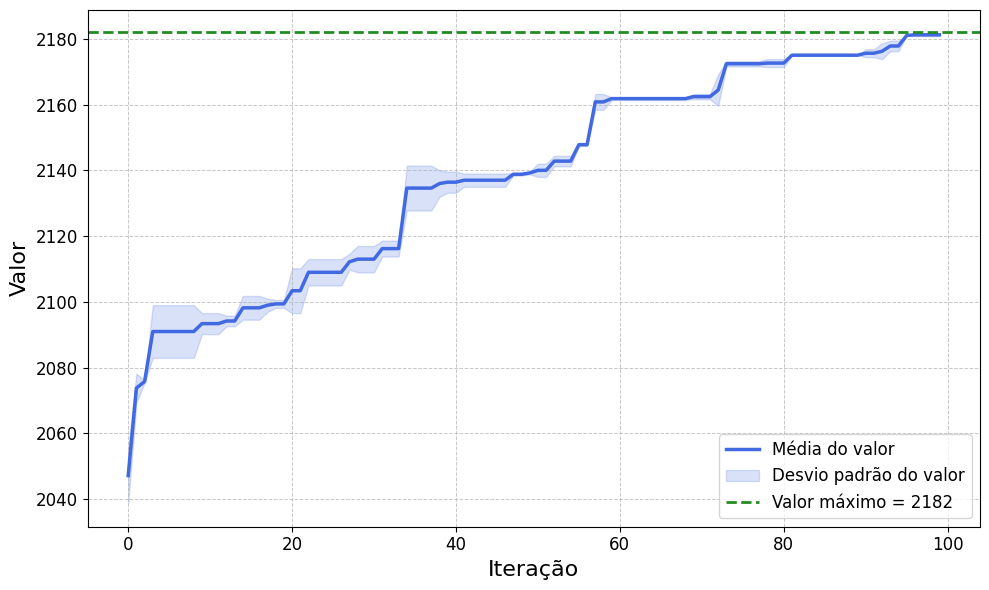

In [6]:
aco_stats.plot_convergence(
    title="Convergência do ACO",
    savefig="results/aco_convergence.pdf"
)